As a beginning exercise for my summer research, I was tasked with coding an equivalent to the enterprise cw_delay function. This was a useful exercise for understanding how the function actually works and how PTAs work. Not entirely relevant to all the work that followed, but someday it could be helpful if I want to try to code a version of cw_delay that accounts for stellar scattering.

Most of my understanding came from Professor Vigeland's CW slideshow, as well as Ellis et al 2012, Ellis's thesis, Joe Simon's thesis, and various NANOGrav papers that all had conflicting and nearly-complete-but-not-quite information. Done with a patchy understanding of waves and PTAs and a nearly nonexistent (or at least non-technical) understanding of GR.

Started by assuming the frequency was constant and coding just the Earth term, not the pulsar term. Imported the antenna pattern:

    create_gw_antenna_pattern(pos, gwtheta, gwphi):
        Function to create pulsar antenna pattern functions as defined
        in Ellis, Siemens, and Creighton (2012).
        :param pos: Unit vector from Earth to pulsar
        :param gwtheta: GW polar angle in radians
        :param gwphi: GW azimuthal angle in radians
        :return: (fplus, fcross, cosMu), where fplus and fcross
                 are the plus and cross antenna pattern functions
                 and cosMu is the cosine of the angle between the
                 pulsar and the GW source.
                 
https://arxiv.org/pdf/1204.4218 (Ellis et al 2012)


I went with a more modular approach, so I defined a function that found the residuals per second based on all the input data (residualPerSec()), and then made a function (cw_delay()) that calls residualPerSec() for every second we want to evaluate the delay at. This made it easier to modify and test, but does not match how enterprise does it.

Yeah, you're going to get a UserWarning saying some package or other is deprecated as an API and slated for removal. Just, like, don't worry about it? It says it's slated for removal as early as 2025-11-30, so like, maybe it'll stop working then, but it's working for me now (2025-08-07) which *definitely* means it'll keep working! 

i lack the spoons to fix it or understand it sorry you're on your own have fun

In [1]:
from enterprise import constants as const
import numpy as np
from enterprise.signals import utils
from enterprise_extensions import deterministic as d
import matplotlib.pyplot as plt

/home/stimmler/miniconda3/envs/ent/lib/python3.12/site-packages/enterprise/signals/utils.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import Requirement, resource_filename


In [2]:
def residualPerSec(t, mass, bDist, w_0, i, psi, pos, gwtheta, gwphi, Phi_0, pulsarTerm, pDist): #just earth term
    """
    Finds the delay from a GW defined by the above parameters, evaluated at a single second in time.
    
    :param t: time you're evaluating the residual at, input time into s(t) [seconds]
    :mass: chirp mass of the binary [solar masses]
    :bDist: luminosity distance to the SMBHB [Mpc i.e. pc * 10^6]
    :w_0: initial frequency of the SMBHB [Hz]
    :i: inclination of the SMBHB with respect to the line of sight [radians, since that's what np uses]
    :psi: polarization angle of the SMBHB [radians]
    :param pos: Unit vector from Earth to pulsar [uhhhhhh]
    :param gwtheta: GW polar angle [radians]
    :param gwphi: GW azimuthal angle [radians]
    :param t_0: initial time this pulsar was observed, t_reff [seconds]
    :param pulsarTerm: are we including the pulsar term or not? [boolean]
    :param pDist: distance to pulsar, no mean or uncertainty sorry [kpc]
    
    :return: a single number--the residual (in seconds) due to a gravitational wave evaluated at the input time
    #still kind of bugs me to calculate "how wrong our time measurement is" evaluated *at* a specific time
    #but I accept the explanation even if it *feels* iffy
    
    """    
    #1 pc = 3 yrs
    #unit conversions to seconds
    mass = mass * const.Tsun #find mass expressed in seconds, rather than solar masses
    bDist = bDist * const.kpc * 1000 / const.c #distance to SMBHB in seconds
    pDist = pDist * const.kpc / const.c #distance to pular in seconds
    
    #antenna pattern
    fPlus, fCross, cosMu = utils.create_gw_antenna_pattern(pos, gwtheta, gwphi)
    
    #get variables for pulsar term
    tp = t - (pDist * (1 - cosMu))
    w_p = w_0 * ( (1 + (256/5) * (mass ** (5/3)) * (w_0 ** (8/3)) * pDist * (1 - cosMu)) ** (-3/8) )
    Phi_p = Phi_0 + (w_p * t) + ( (1/32) * (mass ** (-5/3)) * ((w_0 ** (-5/3)) - (w_p ** (-5/3))) )
    
    #get phase evaluated at this particular time
    Phi_t = Phi(t, w_0, Phi_0)
    
    if pulsarTerm:
        spPlus = getSPlus(mass, bDist, tp, w_p, Phi_p, i, psi)
        spCross = getSCross(mass, bDist, tp, w_p, Phi_p, i, psi)
    sPlus = getSPlus(mass, bDist, t, w_0, Phi_t, i, psi)
    sCross = getSCross(mass, bDist, t, w_0, Phi_t, i, psi)
    
    if pulsarTerm:
        return (fPlus * (spPlus - sPlus)) + (fCross * (spCross - sCross))
    else:
        return (fPlus * sPlus) - (fCross * sCross) #it's minus in the code? but not in any of the papers?

def Phi(t, w_0, Phi_0):
    """
    :param Phi_0: Phi evaluated at t_0
    :param w_o: initial orbital frequency
    :param t: time at which we want to evaluate Phi(t)
    
    returns Phi(t)
    """
    return Phi_0 + (w_0 * t)

def w(t, w_0):
    return None #fix later for evolution bit

def getSPlus(mass, bDist, t, w_0, Phi, i, psi):
    """
    :param mass: mass of source [seconds]
    :param bDist: distance to source/binary [seconds]
    :param t: time being evaluated at [s]
    :param w_0: initial frequency [Hz]
    :param Phi_0: initial phase
    :param i: inclincation [radians]
    :param psi: polarization angle [radians] 
    
    returns the plus term based on inputted variables; 
    note: this is a dumb function that doesn't know whether it's doing this for the pulsar or earth term
    """
    
    alpha = (mass ** (5/3)) / (bDist * (w_0 ** (1/3)))
    At = -np.sin(2 * Phi) * (1 + (np.cos(i) ** 2))
    Bt = 2 * np.cos(2 * Phi) * np.cos(i)
          
    s = alpha * ((At * np.cos(2 * psi)) - (Bt * np.sin(2 * psi)))
    return s

def getSCross(mass, bDist, t, w_0, Phi, i, psi):
    """
    :param mass: mass of source [seconds]
    :param bDist: distance to source/binary [seconds]
    :param t: time being evaluated at [s]
    :param w_0: initial frequency [Hz]
    :param Phi_0: initial phase
    :param i: inclincation [radians]
    :param psi: polarization angle [radians]
    
    returns the cross term based on inputted variables; 
    note: this is a dumb function that doesn't know whether it's doing this for the pulsar or earth term
    """
    
    alpha = (mass ** (5/3)) / (bDist * (w_0 ** (1/3)))
    At = -np.sin(2 * Phi) * (1 + (np.cos(i) ** 2))
    Bt = 2 * np.cos(2 * Phi) * np.cos(i)
          
    s = alpha * ((At * np.sin(2 * psi)) + (Bt * np.cos(2 * psi)))
    return s

In [3]:
def cw_delay(TOAs, mass, bDist, w_0, i, psi, pos, gwtheta, gwphi, Phi_0, pulsarTerm, pDist): #just earth term
    """
    #where TOAs is an array of the times of arrival
    #index 0 of TOAs contains the first TOA in seconds, 1 contains the second, so on
    other parameters explained above, in the residualPerSec function
    
    returns an array/list of GW-induced residuals in seconds
    """
    t_0 = TOAs[0] #I think this is "tref" in enterprise--it's our t_0, the time at which the data starts
    residuals = []
    for t in range (len(TOAs)):
        TOAs[t] = TOAs[t] - t_0 #redefined to zero to match enterprise function
        residuals.append(residualPerSec(TOAs[t], mass, bDist, w_0, i, psi, pos, gwtheta, gwphi, Phi_0, pulsarTerm, pDist))   
    return residuals;
        
"""
checking I matched all the inputs of the enterprise function: 

toas, x
    pos, x
    pdist, x
    cos_gwtheta=0, did gwtheta instead
    gwphi=0, x
    cos_inc=0, did i instead
    log10_mc=9, x log10 of chirp mass--I didn't do log ten
    log10_fgw=-8, x frequency of the GW (twice orbital frequency); I did orbital freq
    log10_dist=None, x luminosity distance, I didn't do log ten
    log10_h=None, ? strain, used to compute distance
    // I guess you either have the distance or the strain? yes, correct
    phase0=0 x
    psi=0, x but not initialized, but I guess it makes sense that the default is zero
    psrTerm=False, ?
    p_dist=0, ?
    p_phase=None, ?
    evolve=False, phase_approx=False, check=False - evolution of . . . which? probably GW I guess, we haven't talked much about the frequency/evolution of the pulsar
    tref=0, ?
    """

"\nchecking I matched all the inputs of the enterprise function: \n\ntoas, x\n    pos, x\n    pdist, x\n    cos_gwtheta=0, did gwtheta instead\n    gwphi=0, x\n    cos_inc=0, did i instead\n    log10_mc=9, x log10 of chirp mass--I didn't do log ten\n    log10_fgw=-8, x frequency of the GW (twice orbital frequency); I did orbital freq\n    log10_dist=None, x luminosity distance, I didn't do log ten\n    log10_h=None, ? strain, used to compute distance\n    // I guess you either have the distance or the strain? yes, correct\n    phase0=0 x\n    psi=0, x but not initialized, but I guess it makes sense that the default is zero\n    psrTerm=False, ?\n    p_dist=0, ?\n    p_phase=None, ?\n    evolve=False, phase_approx=False, check=False - evolution of . . . which? probably GW I guess, we haven't talked much about the frequency/evolution of the pulsar\n    tref=0, ?\n    "

Below, I ran my code and enterprise's code on the same data to make sure that they're producing the same results. Just generated evenly (? linspace) spaced timestamps from my date of birth to the day I started working on this project. Used what I think are reasonable example values, defined below under "example values." They overlap, so I did my work correctly!

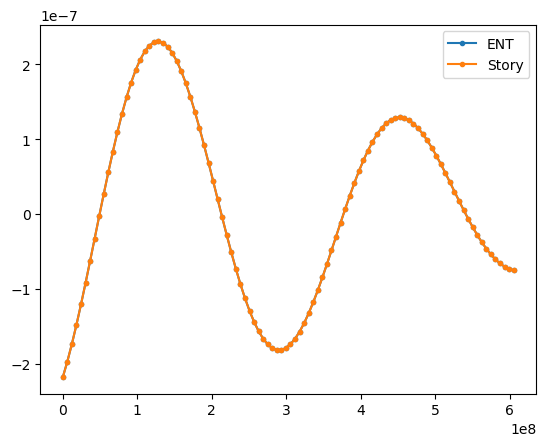

In [4]:
#TOAs
start = 53830 * 3600 * 24 #starts for the TOAs
end = 60839 * 3600 * 24 #end for the TOAs
testTOAs = np.linspace(start, end, 100)

#example values
testM = 10 ** 9.5 #10^10 solar masses
testDist = 73.79 #Mpc; distance of the SMBHB candidate mentioned in the 12.5yr CW paper
testw_0 = 10 ** -8 #10 nHz
testI = np.pi/2 #in radians; edge-on
testPsi = np.pi/4
testPos =  np.array([0.237, -0.754, -0.612])
testgwtheta = np.pi/2
testgwphi = np.pi
testPhi_0 = 0 #just for ease, why not
testPDist = 8 #1 kpc

#my own function
residuals = cw_delay(testTOAs, testM, testDist, testw_0, testI, testPsi, testPos, testgwtheta, testgwphi, testPhi_0, True, testPDist)

#the enterprise function
log_10fgw = np.log10(testw_0/np.pi)
res = d.cw_delay(testTOAs, testPos, [8, 0.2], 
                 0, np.pi, 0, np.log10(testM), log_10fgw, np.log10(testDist), None, testPhi_0, testPsi, 
                 True, 0, None, False, True, False, testTOAs[0])

plt.plot(testTOAs, res, marker='.', ls='-', alpha=1, label='ENT')
plt.plot(testTOAs, residuals, marker='.', ls='-', alpha=1, label='Story')
plt.legend()

The following is code used to make a figure for my presentation. Currently showing a signal with no pulsar term and not really any evolution. If you want something with the pulsar term, pass "True" in place of "False" after "testPhi_0." This is setting the parameter pulsarTerm to True. The rest of the function is such that it will have a reasonable pulsar term.

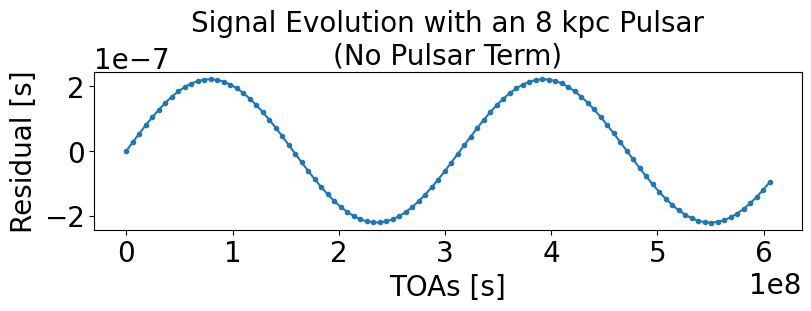

In [5]:
graphResiduals = cw_delay(testTOAs, testM, testDist, testw_0, testI, testPsi, testPos, testgwtheta, testgwphi, testPhi_0, False, testPDist)

plt.rcParams['font.size'] = 20

# Create a grid of 2 rows and 3 columns, and use gridspec to span subplots
#fig, axs = plt.subplots(1, 2, layout="constrained", figsize = (4, 3))
fig, ax = plt.subplots(1, 1, layout="constrained", figsize = (8, 3))

ax.plot(testTOAs, graphResiduals, marker=".", ls='-', alpha=1)
ax.set_xlabel('TOAs [s]', fontsize = 20)
ax.set_ylabel('Residual [s]', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title("Signal Evolution with an 8 kpc Pulsar\n(No Pulsar Term)", fontsize = 20)
#plt.legend();

fig.savefig("noSignalEvolution", transparent = True)

plt.show()

Below, I copied and pasted the enterprise code so that I could see it and edit it (mostly with print statements) to understand it and compare it to my own code. Not actually being used anywhere else in the notebook currently.

In [6]:
def ent_cw_delay(
    toas,
    pos,
    pdist,
    cos_gwtheta=0,
    gwphi=0,
    cos_inc=0,
    log10_mc=9,
    log10_fgw=-8,
    log10_dist=None,
    log10_h=None,
    phase0=0,
    psi=0,
    psrTerm=False,
    p_dist=1,
    p_phase=None,
    evolve=False,
    phase_approx=False,
    check=False,
    tref=0,
):
    """
    Function to create GW incuced residuals from a SMBMB as
    defined in Ellis et. al 2012,2013.

    :param toas:
        Pular toas in seconds
    :param pos:
        Unit vector from the Earth to the pulsar
    :param pdist:
        Pulsar distance (mean and uncertainty) [kpc]
    :param cos_gwtheta:
        Cosine of Polar angle of GW source in celestial coords [radians]
    :param gwphi:
        Azimuthal angle of GW source in celestial coords [radians]
    :param cos_inc:
        cosine of Inclination of GW source [radians]
    :param log10_mc:
        log10 of Chirp mass of SMBMB [solar masses]
    :param log10_fgw:
        log10 of Frequency of GW (twice the orbital frequency) [Hz]
    :param log10_dist:
        log10 of Luminosity distance to SMBMB [Mpc],
        used to compute strain, if not None
    :param log10_h:
        log10 of GW strain,
        used to compute distance, if not None
    :param phase0:
        Initial GW phase of source [radians]
    :param psi:
        Polarization angle of GW source [radians]
    :param psrTerm:
        Option to include pulsar term [boolean]
    :param p_dist:
        Pulsar distance parameter
    :param p_phase:
        Use pulsar phase to determine distance [radian]
    :param evolve:
        Option to include/exclude full evolution [boolean]
    :param phase_approx:
        Option to include/exclude phase evolution across observation time
        [boolean]
    :param check:
        Check if frequency evolves significantly over obs. time [boolean]
    :param tref:
        Reference time for phase and frequency [s]

    :return: Vector of induced residuals

    """

    # convert units to time
    mc = 10**log10_mc * const.Tsun
    fgw = 10**log10_fgw
    gwtheta = np.arccos(cos_gwtheta)
    inc = np.arccos(cos_inc)
    p_dist = (pdist[0] + pdist[1] * p_dist) * const.kpc / const.c

    if log10_h is None and log10_dist is None:
        raise ValueError("one of log10_dist or log10_h must be non-None")
    elif log10_h is not None and log10_dist is not None:
        raise ValueError("only one of log10_dist or log10_h can be non-None")
    elif log10_h is None:
        dist = 10**log10_dist * const.Mpc / const.c
    else:
        dist = 2 * mc ** (5 / 3) * (np.pi * fgw) ** (2 / 3) / 10**log10_h

    if check:
        # check that frequency is not evolving significantly over obs. time
        fstart = fgw * (1 - 256 / 5 * mc ** (5 / 3) * fgw ** (8 / 3) * toas[0]) ** (
            -3 / 8
        )
        fend = fgw * (1 - 256 / 5 * mc ** (5 / 3) * fgw ** (8 / 3) * toas[-1]) ** (
            -3 / 8
        )
        df = fend - fstart

        # observation time
        Tobs = toas.max() - toas.min()
        fbin = 1 / Tobs

        if np.abs(df) > fbin:
            print("WARNING: Frequency is evolving over more than one " "frequency bin.")
            print(
                "f0 = {0}, f1 = {1}, df = {2}, fbin = {3}".format(
                    fstart, fend, df, fbin
                )
            )
            return np.ones(len(toas)) * np.nan

    # get antenna pattern funcs and cosMu
    # write function to get pos from theta,phi
    fplus, fcross, cosMu = utils.create_gw_antenna_pattern(pos, gwtheta, gwphi)

    # get pulsar time
    toas -= tref
    if p_dist > 0:
        tp = toas - p_dist * (1 - cosMu)
    else:
        tp = toas
        
    print(tp)
    print(p_dist)

    # orbital frequency
    w0 = np.pi * fgw
    phase0 /= 2  # convert GW to orbital phase
    # omegadot = 96/5 * mc**(5/3) * w0**(11/3) # Not currently used in code

    # evolution
    if evolve:
        # calculate time dependent frequency at earth and pulsar
        omega = w0 * (1 - 256 / 5 * mc ** (5 / 3) * w0 ** (8 / 3) * toas) ** (-3 / 8)
        omega_p = w0 * (1 - 256 / 5 * mc ** (5 / 3) * w0 ** (8 / 3) * tp) ** (-3 / 8)

        if p_dist > 0:
            omega_p0 = w0 * (
                1 + 256 / 5 * mc ** (5 / 3) * w0 ** (8 / 3) * p_dist * (1 - cosMu)
            ) ** (-3 / 8)
        else:
            omega_p0 = w0

        # calculate time dependent phase
        phase = phase0 + 1 / 32 / mc ** (5 / 3) * (w0 ** (-5 / 3) - omega ** (-5 / 3))

        if p_phase is None:
            phase_p = phase0 + 1 / 32 / mc ** (5 / 3) * (
                w0 ** (-5 / 3) - omega_p ** (-5 / 3)
            )
        else:
            phase_p = (
                phase0
                + p_phase
                + 1 / 32 * mc ** (-5 / 3) * (omega_p0 ** (-5 / 3) - omega_p ** (-5 / 3))
            )

    elif phase_approx:
        # monochromatic
        omega = w0
        if p_dist > 0:
            omega_p = w0 * (
                1 + 256 / 5 * mc ** (5 / 3) * w0 ** (8 / 3) * p_dist * (1 - cosMu)
            ) ** (-3 / 8)
            print("pdist was greater than zero, used the expression")
        else:
            omega_p = w0
            print("pdist was not greater than zero, automatically assigned w0")

        # phases
        phase = phase0 + omega * toas
        if p_phase is not None:
            phase_p = phase0 + p_phase + omega_p * toas
        else:
            phase_p = (
                phase0
                + omega_p * toas
                + 1 / 32 / mc ** (5 / 3) * (w0 ** (-5 / 3) - omega_p ** (-5 / 3))
            )
            
        print("Ent Phi_p: " + str(phase_p))
        print("Ent w_p: " + str(omega_p))

    # no evolution
    else:
        # monochromatic
        omega = np.pi * fgw
        omega_p = omega

        # phases
        phase = phase0 + omega * toas
        phase_p = phase0 + omega * tp

    # define time dependent coefficients
    At = -0.5 * np.sin(2 * phase) * (3 + np.cos(2 * inc))
    Bt = 2 * np.cos(2 * phase) * np.cos(inc)
    At_p = -0.5 * np.sin(2 * phase_p) * (3 + np.cos(2 * inc))
    Bt_p = 2 * np.cos(2 * phase_p) * np.cos(inc)

    # now define time dependent amplitudes
    alpha = mc ** (5.0 / 3.0) / (dist * omega ** (1.0 / 3.0))
    alpha_p = mc ** (5.0 / 3.0) / (dist * omega_p ** (1.0 / 3.0))

    # define rplus and rcross
    rplus = alpha * (-At * np.cos(2 * psi) + Bt * np.sin(2 * psi))
    rcross = alpha * (At * np.sin(2 * psi) + Bt * np.cos(2 * psi))
    rplus_p = alpha_p * (-At_p * np.cos(2 * psi) + Bt_p * np.sin(2 * psi))
    rcross_p = alpha_p * (At_p * np.sin(2 * psi) + Bt_p * np.cos(2 * psi))

    # residuals
    if psrTerm:
        res = fplus * (rplus_p - rplus) + fcross * (rcross_p - rcross)
    else:
        res = -fplus * rplus - fcross * rcross

    return res